# Modelo de Red Neuronal LSTM para predicción de ocupación hospitalaria

# Importación y preparación de Datos

## Datos de ocupación

In [73]:
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np

In [74]:
from datetime import datetime, timedelta
import requests
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns

In [75]:
df = pd.read_csv("./Data/ocupación.csv",sep=";")
df.head(2)

,Grupo ocupación,Fecha corte,DISPONIBLE,OCUPADA
0,OCUPACIÓN HOSPITALIZACIÓN,16/06/2020 3:02:03 a.m.,87,162
1,OCUPACIÓN HOSPITALIZACIÓN,16/06/2020 6:01:26 a.m.,83,166


Creación de campos

In [76]:
df['CAMAS TOTALES'] = df['DISPONIBLE'] + df['OCUPADA']
df['% OCUPACION'] = (df['OCUPADA'] / df['CAMAS TOTALES'])

Arreglo del campo fecha

In [77]:
#extraer solo la fecha
df['Fecha corte'] = df['Fecha corte'].str.split().str[0]
df['Fecha corte'] = pd.to_datetime(df['Fecha corte'], format='%d/%m/%Y', errors='coerce')

Filtro Grupo Ocupación

In [78]:
df['Grupo ocupación'].value_counts()

Grupo ocupación
OCUPACIÓN HOSPITALIZACIÓN    2569
OCUPACIÓN UCI                2569
Name: count, dtype: int64

In [79]:
#filtro ocupación hospitalización ya que solo nos enfocamos en hospitalización
df = df[df['Grupo ocupación'] != 'OCUPACIÓN UCI']
df = df.drop('Grupo ocupación', axis=1)

Eliminar fechas duplicadas

In [80]:
df = df.sort_values('% OCUPACION').drop_duplicates(subset=['Fecha corte'], keep='last')
#convertir fecha en index
df = df.set_index('Fecha corte')
df = df.sort_values('Fecha corte')

Rango de fechas de el dataframe

In [81]:
print(df.index.min(), df.index.max())

2020-06-16 00:00:00 2024-12-01 00:00:00


Validación de fechas vacias

In [82]:
fecha_inicio = df.index.min()
fecha_fin = df.index.max()
rango_fechas = pd.date_range(start=fecha_inicio, end=fecha_fin)

# crear dataset con rango de fechas
date_df = pd.DataFrame({'Fecha corte': rango_fechas})
date_df = date_df.set_index('Fecha corte')
# Unir
df = date_df.merge(df, how='left', left_index=True, right_index=True)

In [83]:
df.isnull().sum()

DISPONIBLE       57
OCUPADA          57
CAMAS TOTALES    57
% OCUPACION      57
dtype: int64

In [84]:
meses = {
    'enero': '01', 'febrero': '02', 'marzo': '03',
    'abril': '04', 'mayo': '05', 'junio': '06',
    'julio': '07', 'agosto': '08', 'septiembre': '09',
    'octubre': '10', 'noviembre': '11', 'diciembre': '12'
}

In [85]:
# Función para convertir texto de fecha
def convertir_fecha(texto):
    for mes, num in meses.items():
        if mes in texto:
            texto = texto.replace(f" de {mes} de ", f"-{num}-")
            break
    return datetime.strptime(texto, '%d-%m-%Y').date()

In [86]:
df['OCUPADA'] = pd.to_numeric(df['OCUPADA'], errors='coerce')

# Analisis Exploratorio

In [87]:
df.dtypes

DISPONIBLE       float64
OCUPADA          float64
CAMAS TOTALES    float64
% OCUPACION      float64
dtype: object

## Grafica de comportamiento Variables a Trabajar

<Figure size 1500x500 with 0 Axes>

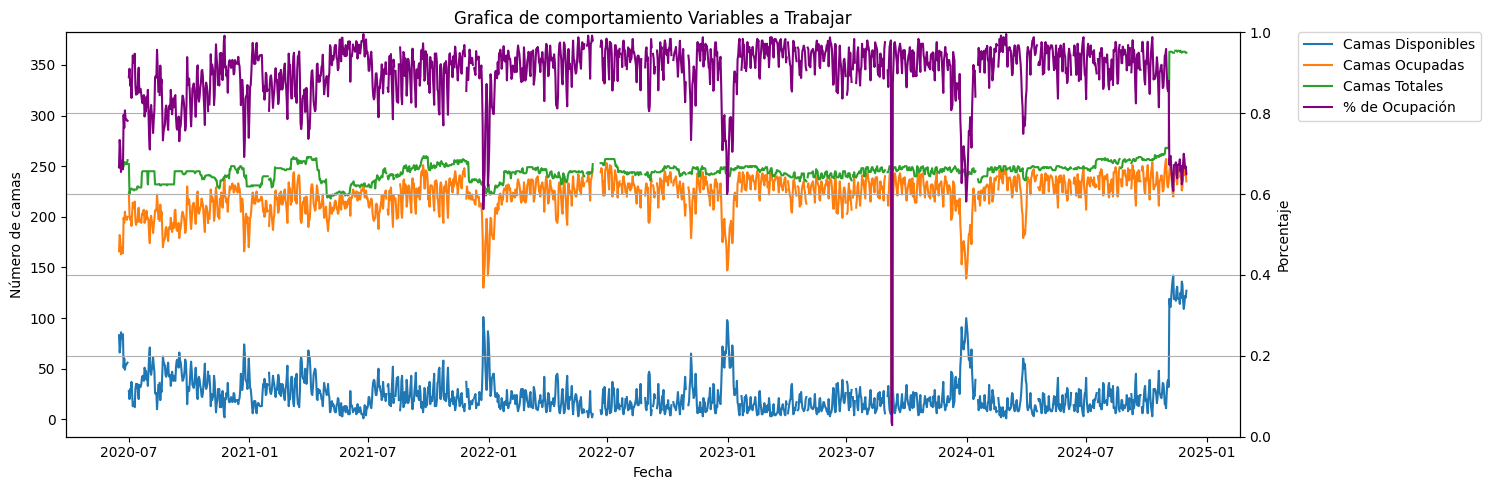

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Primer eje y (Camas Disponibles, Ocupadas y Totales)
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(df.index, df['DISPONIBLE'], label='Camas Disponibles')
ax1.plot(df.index, df['OCUPADA'], label='Camas Ocupadas')
ax1.plot(df.index, df['CAMAS TOTALES'], label='Camas Totales')
ax1.set_ylabel('Número de camas')

# Segundo eje y (Porcentajes)
ax2 = ax1.twinx()
ax2.set_ylim(0, None)
ax2.plot(df.index, df['% OCUPACION'], color='purple', label='% de Ocupación')
ax2.set_ylabel('Porcentaje')

# Configuración de la leyenda
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)

# Configuración adicional
ax1.set_xlabel('Fecha')
plt.title('Grafica de comportamiento Variables a Trabajar')
plt.grid()
plt.tight_layout()  # Ajusta automáticamente los márgenes
plt.show()


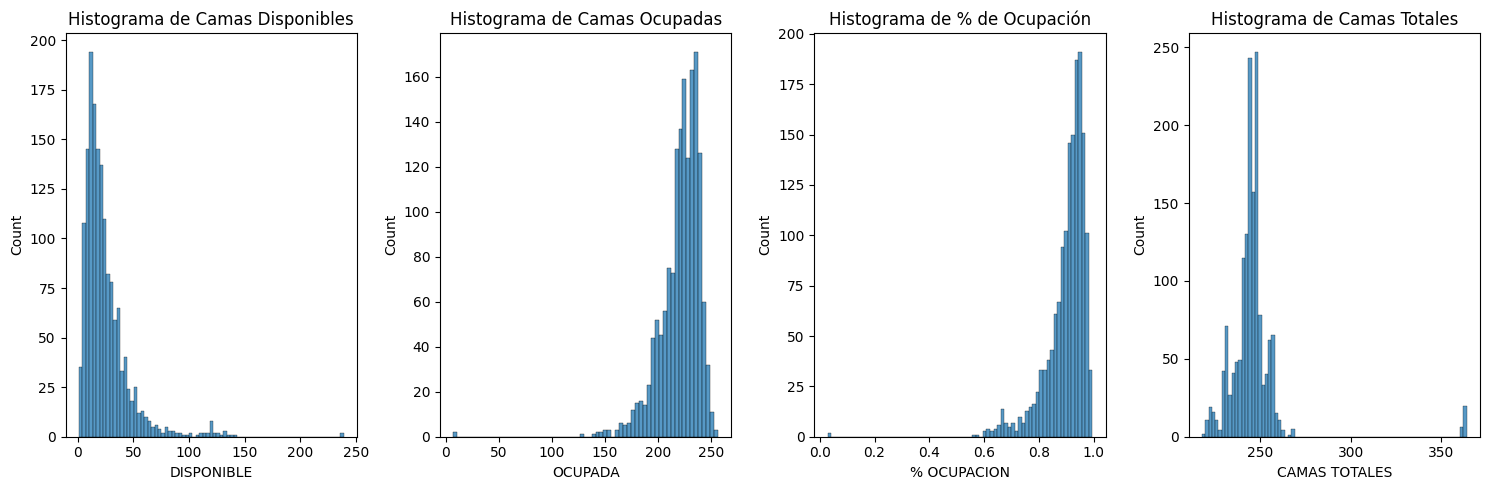

In [90]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

sns.histplot(df['DISPONIBLE'], ax=axes[0])
axes[0].set_title('Histograma de Camas Disponibles')

sns.histplot(df['OCUPADA'], ax=axes[1])
axes[1].set_title('Histograma de Camas Ocupadas')

sns.histplot(df['% OCUPACION'], ax=axes[2])
axes[2].set_title('Histograma de % de Ocupación')

sns.histplot(df['CAMAS TOTALES'], ax=axes[3])
axes[3].set_title('Histograma de Camas Totales')

plt.tight_layout()
plt.show()

<Axes: >

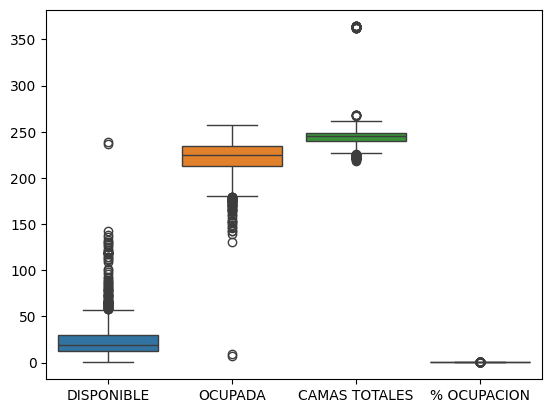

In [91]:
sns.boxplot(data=df[['DISPONIBLE', 'OCUPADA', 'CAMAS TOTALES', '% OCUPACION']])

<Axes: >

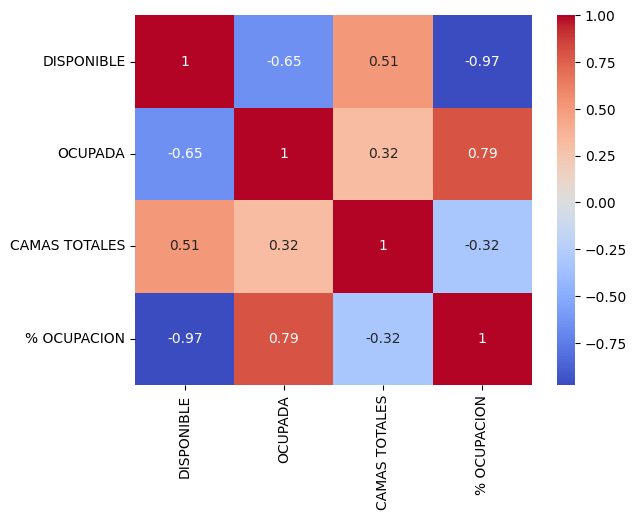

In [92]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

#Preprocesamiento

In [93]:
#filtro de datos luego de 2024-11
df_preprocessed = df[df.index < datetime(2024, 5, 29)]

##Inputar faltantes

In [94]:
#borrar outliers
df_preprocessed.loc[df_preprocessed['OCUPADA'] < 15, ['OCUPADA','DISPONIBLE','CAMAS TOTALES','% OCUPACION']] = np.nan

In [ ]:
# Imputar valores faltantes por la mediana
for column in ['OCUPADA', 'DISPONIBLE', 'CAMAS TOTALES', '% OCUPACION']:
    median_value = df_preprocessed[column].median()
    df_preprocessed[column].fillna(median_value, inplace=True)

In [96]:
df_preprocessed.isnull().sum()

DISPONIBLE       0
OCUPADA          0
CAMAS TOTALES    0
% OCUPACION      0
dtype: int64

<Figure size 1500x500 with 0 Axes>

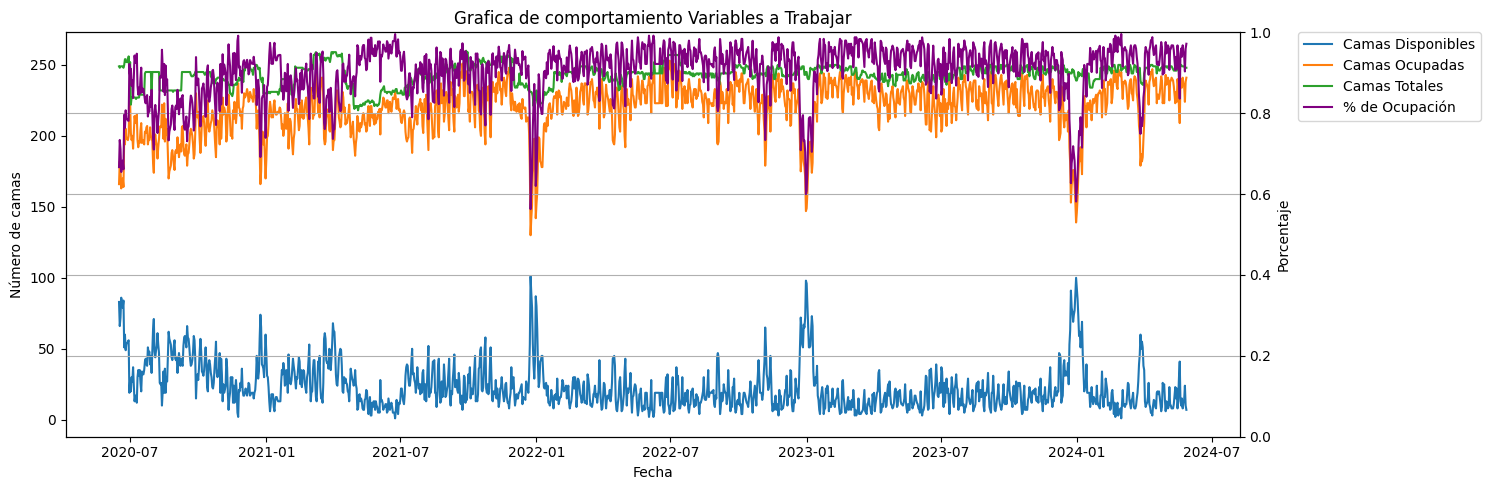

In [97]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Primer eje y (Camas Disponibles, Ocupadas y Totales)
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(df_preprocessed.index, df_preprocessed['DISPONIBLE'], label='Camas Disponibles')
ax1.plot(df_preprocessed.index, df_preprocessed['OCUPADA'], label='Camas Ocupadas')
ax1.plot(df_preprocessed.index, df_preprocessed['CAMAS TOTALES'], label='Camas Totales')
ax1.set_ylabel('Número de camas')

# Segundo eje y (Porcentajes)
ax2 = ax1.twinx()
ax2.set_ylim(0, None)
ax2.plot(df_preprocessed.index, df_preprocessed['% OCUPACION'], color='purple', label='% de Ocupación')
ax2.set_ylabel('Porcentaje')

# Configuración de la leyenda
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)

# Configuración adicional
ax1.set_xlabel('Fecha')
plt.title('Grafica de comportamiento Variables a Trabajar')
plt.grid()
plt.tight_layout()
plt.show()


## Estandarización

<Axes: >

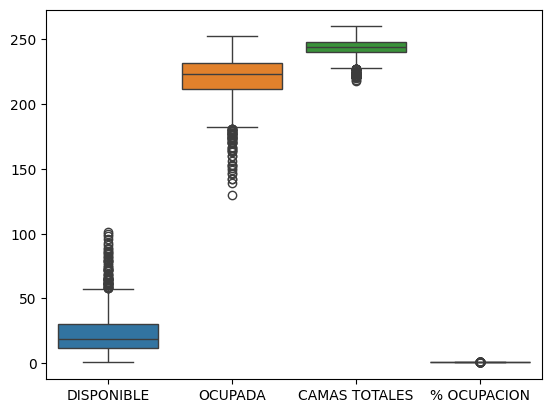

In [98]:
sns.boxplot(df_preprocessed)

Variable a predecir

In [99]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [100]:
minmaxscaler = MinMaxScaler(feature_range=(-1,1))
df_preprocessed['% OCUPACION'] = minmaxscaler.fit_transform(df_preprocessed[['% OCUPACION']])

C:\Users\michael.gomez\AppData\Local\Temp\ipykernel_21528\538683191.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed['% OCUPACION'] = minmaxscaler.fit_transform(df_preprocessed[['% OCUPACION']])


componentes predictores

In [ ]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the selected columns and transform them
for column in ['DISPONIBLE', 'OCUPADA', 'CAMAS TOTALES']:
    df_preprocessed[column] = scaler.fit_transform(df_preprocessed[[column]])

<Axes: >

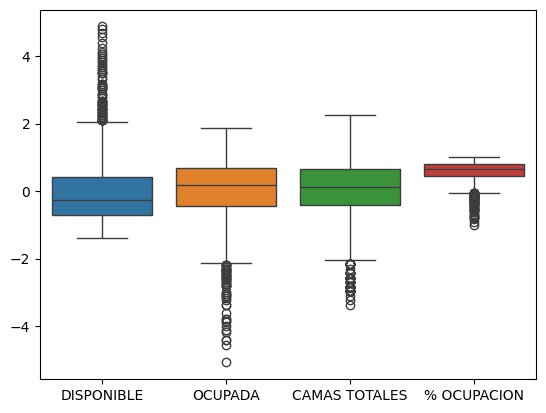

In [102]:
sns.boxplot(df_preprocessed)

##Separación de grupos

In [103]:
Df_Train = df_preprocessed.loc["2020-06-16":"2023-06-16"]
DF_Validation = df_preprocessed.loc["2023-06-17":"2023-12-31"]
DF_Test = df_preprocessed.loc["2024-01-01":]

<Figure size 1500x500 with 0 Axes>

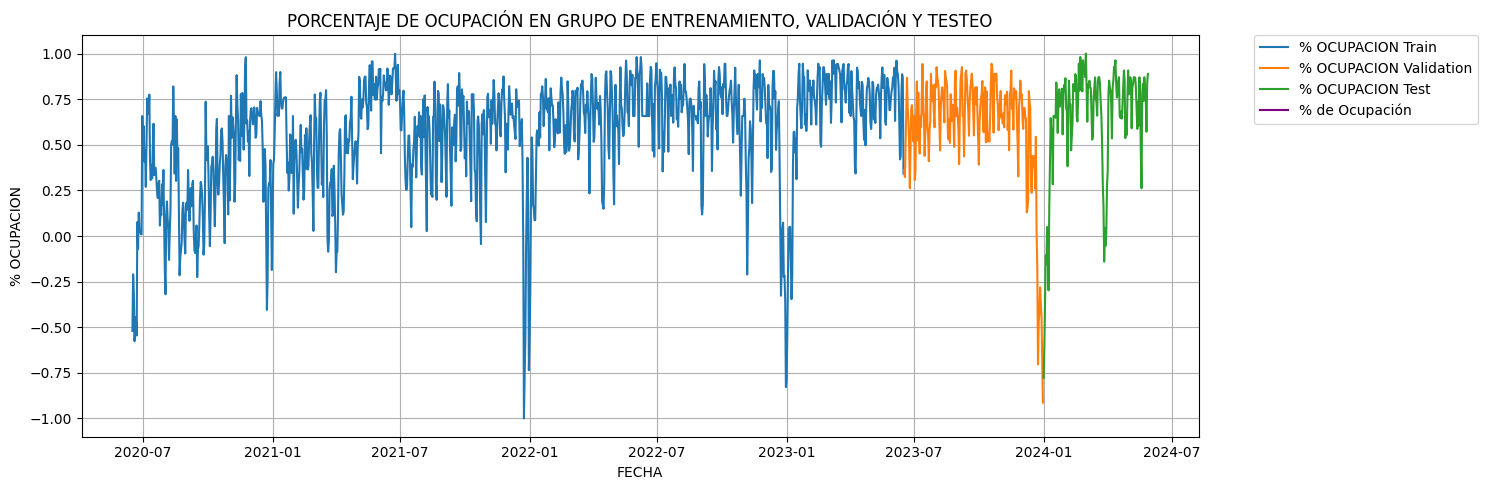

In [104]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Primer eje y (Camas Disponibles, Ocupadas y Totales)
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(Df_Train.index, Df_Train['% OCUPACION'], label='% OCUPACION Train')
ax1.plot(DF_Validation.index, DF_Validation['% OCUPACION'], label='% OCUPACION Validation')
ax1.plot(DF_Test.index, DF_Test['% OCUPACION'], label='% OCUPACION Test')
ax1.set_ylabel('% OCUPACION')



# Configuración de la leyenda
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)

# Configuración adicional
ax1.set_xlabel('FECHA')
plt.title('PORCENTAJE DE OCUPACIÓN EN GRUPO DE ENTRENAMIENTO, VALIDACIÓN Y TESTEO')
plt.grid()
plt.tight_layout()  # Ajusta automáticamente los márgenes
plt.show()

convertir a arreglo numpy

## Arreglos lookback

In [107]:
lookback = 30
def create_sequences_multivariate(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length), :3]  # Selecciona todas las features
        y = data[i+seq_length, 3]      # Asume que la columna 3 es la variable objetivo
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Uso de la nueva función
X_train, y_train = create_sequences_multivariate(Df_Train.values, lookback)
X_val, y_val = create_sequences_multivariate(DF_Validation.values, lookback)
X_test, y_test = create_sequences_multivariate(DF_Test.values, lookback)


# Creación y entrenamiento de modelo

In [ ]:
#resultados de gridsearch {'units': 128, 'dropout_rate': 0.3, 'dense_units': 32, 'epochs': 20, 'batch_size': 32}

In [162]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Definir el modelo
model = Sequential()
model.add(LSTM(128, input_shape=(30, 3), return_sequences=False))  # Una capa LSTM
# # Segunda capa LSTM
model.add(Dropout(0.3))  # Dropout adicional
model.add(Dense(32, activation='linear'))  # Otra capa más pequeña para refinar la secuencia
model.add(Dense(1, activation='linear'))  # Predicción de una sola salida (por ejemplo, % OCUPACION)

# Compilar el modelo
optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

# Entrenamiento
modellstm = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/40


c:\Users\michael.gomez\Projects-ML\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.1363 - mse: 0.1363 - val_loss: 0.0481 - val_mse: 0.0481
Epoch 2/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0519 - mse: 0.0519 - val_loss: 0.0302 - val_mse: 0.0302
Epoch 3/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0420 - mse: 0.0420 - val_loss: 0.0309 - val_mse: 0.0309
Epoch 4/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0420 - mse: 0.0420 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 5/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0403 - mse: 0.0403 - val_loss: 0.0284 - val_mse: 0.0284
Epoch 6/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0373 - mse: 0.0373 - val_loss: 0.0281 - val_mse: 0.0281
Epoch 7/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0359 - mse: 0.0359 - val_loss: 0.0322 - val_mse: 0.0322
Epoch 8/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0360 - mse: 0.0360 - val_loss: 0.0266 - val_mse: 0.0266
Epoch 9/40
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0347 - mse: 0.

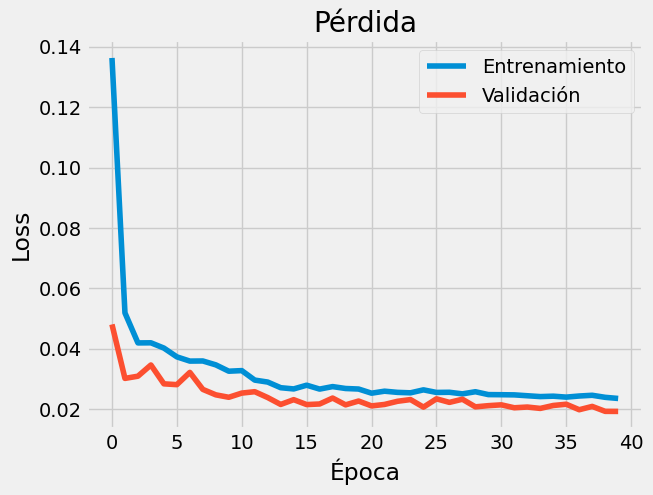

In [163]:
import matplotlib.pyplot as plt

# Graficar pérdida
plt.plot(modellstm.history['loss'], label='Entrenamiento')
plt.plot(modellstm.history['val_loss'], label='Validación')
plt.title('Pérdida')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()


#Evaluación del modelo

In [109]:
# Evaluar el modelo
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Resultado de entrenamiento: %.5f MSE' % (trainScore[0]))
validationScore = model.evaluate(X_val, y_val, verbose=0)
print('Resultado de validación: %.5f MSE' % (validationScore[0]))
testScore = model.evaluate(X_test, y_test, verbose=0)
print('Resultado de prueba: %.5f MSE' % (testScore[0]))

Resultado de entrenamiento: 0.02211 MSE
Resultado de validación: 0.01990 MSE
Resultado de prueba: 0.02041 MSE


In [111]:
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_val)
test_predictions = model.predict(X_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [113]:
fechas_train = Df_Train.index.to_numpy()
fechas_validacion = DF_Validation.index.to_numpy()
fechas_test = DF_Test.index.to_numpy()

In [114]:
train_predictions = train_predictions.reshape(-1)
fechas_train = fechas_train[:len(train_predictions)]

val_predictions = val_predictions.reshape(-1)
fechas_validacion = fechas_validacion[:len(val_predictions)]

test_predictions = test_predictions.reshape(-1)
fechas_test = fechas_test[:len(test_predictions)]

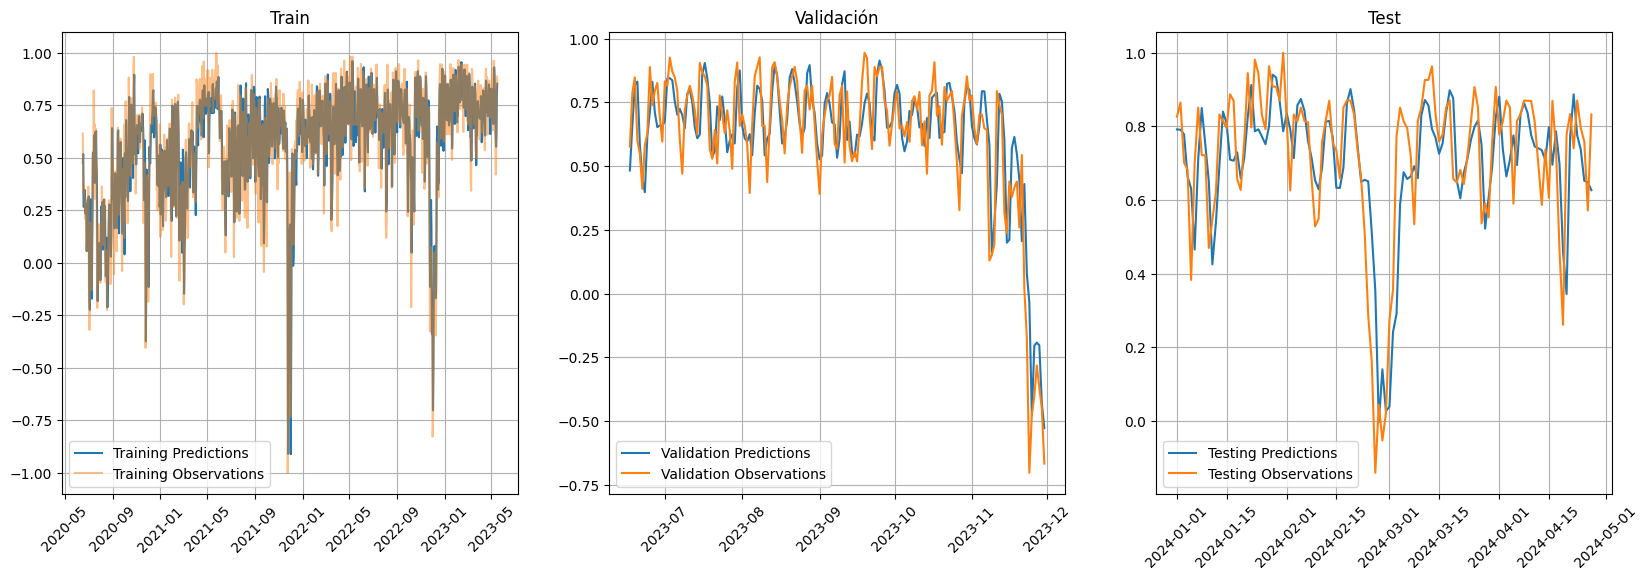

In [115]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Gráfico 1: Predicciones de entrenamiento vs. Observaciones de entrenamiento
axes[0].plot(fechas_train, train_predictions, label='Training Predictions')
axes[0].plot(fechas_train, y_train, label='Training Observations',alpha=0.5)
axes[0].set_title('Train')
axes[0].legend()
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=45)

# Gráfico 2: Predicciones de validación vs. Observaciones de validación
axes[1].plot(fechas_validacion, val_predictions, label='Validation Predictions')
axes[1].plot(fechas_validacion, y_val, label='Validation Observations')
axes[1].set_title('Validación')
axes[1].legend()
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=45)


# Gráfico 3: Predicciones de prueba vs. Observaciones de prueba
axes[2].plot(fechas_test, test_predictions, label='Testing Predictions')
axes[2].plot(fechas_test, y_test, label='Testing Observations')
axes[2].set_title('Test')
axes[2].legend()
axes[2].grid(True)
axes[2].tick_params(axis='x', rotation=45)


#plt.tight_layout()
plt.show()

In [116]:
# Desescalar datos

test_predictions_original_scale = minmaxscaler.inverse_transform(test_predictions.reshape(-1, 1))
y_test_original_scale = minmaxscaler.inverse_transform(y_test.reshape(-1, 1))

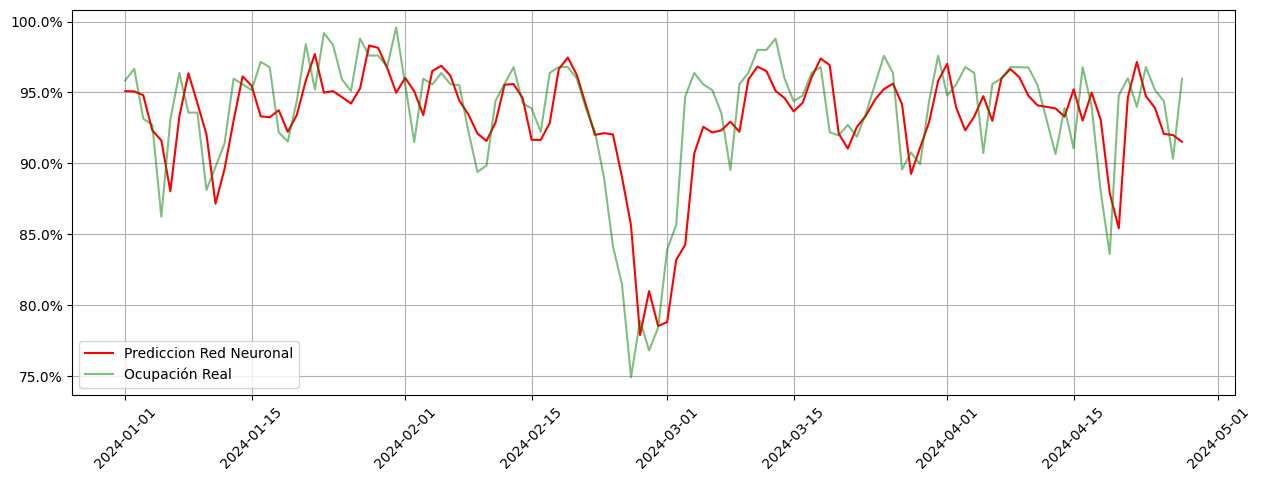

In [147]:
from matplotlib.ticker import PercentFormatter
plt.figure(figsize=(15, 5))
plt.plot(fechas_test, test_predictions_original_scale, label='Prediccion Red Neuronal',c='r')
plt.plot(fechas_test, y_test_original_scale, label='Ocupación Real',c='g',alpha= 0.5)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))  # Cambia xmax=1 si los datos ya están en decimales
plt.legend()
plt.grid(True)
plt.tick_params(axis='x', rotation=45)

In [121]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_original_scale, test_predictions_original_scale)
mae = mean_absolute_error(y_test_original_scale, test_predictions_original_scale)
rmse = np.sqrt(mse)

print('Diferencia de Error entre Predicción de la Red Neuronal y la Ocupación Real')
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

Diferencia de Error entre Predicción de la Red Neuronal y la Ocupación Real
Mean Squared Error (MSE): 0.0009571547288828136
Mean Squared Error (RMSE): 0.030937917332665002
Mean Absolute Error (MAE): 0.02291145133723788
